# Implémentez un modèle de scoring

## SOMMAIRE

### [INTRODUCTION](#INTRODUCTION)
- [Contexte](#Contexte)
- [Objectifs](#Objectifs)

### [Notebook de Modélisation](#ETAPE-0-:-Notebook-de-modélisation)
- [1. Importation des Bibliothèques](#Importation-des-Bibliothèques)
- [2. Importation des données](#Importation-des-données)
- [3. Séparation des features et de la cible et train_test_split](#Séparation-des-features-et-de-la-cible)
- [4. Modèle **DummyClassifier** (baseline)](#DummyClassifier-(baseline))
- [5. Modèle **Régression Logistique** avec gestion du déséquilibre des classes)](#Modèle-**Régression-Logistique**-avec-gestion-du-déséquilibre-des-classes)
- [6. Modèle **RandomForest** avec gestion du déséquilibre des classes](#Modèle-**RandomForest**-avec-gestion-du-déséquilibre-des-classes)
- [7. Modèle **XGBoost** avec gestion du déséquilibre des classes](#Modèle-**XGBoost**-avec-gestion-du-déséquilibre-des-classes)
- [8. Modèle **LightGBM** avec gestion du déséquilibre des classes](#Modèle-**LightGBM**-avec-gestion-du-déséquilibre-des-classes)
- [9. Optimisation des hyperparamètres pour tous les modèles et Evaluation](#Optimisation-des-hyperparamètres)


# __________________________________________________________________________________________

# 1. Importation des Bibliothèques <a id="Importation-des-Bibliothèques"></a>

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import glob
import pickle
import os
import matplotlib.pyplot as plt
from pathlib import Path
import multiprocessing
import platform
import cpuinfo
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc
import os
import time
import mlflow
import mlflow.sklearn
import tempfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, classification_report,precision_recall_curve, confusion_matrix, precision_score, 
recall_score)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


In [6]:
import ipywidgets as widgets
widgets.IntSlider(description="Test")

IntSlider(value=0, description='Test')

In [7]:
# Nom du processeur
cpu = cpuinfo.get_cpu_info()
print("Nom du CPU :", cpu['brand_raw'])

# Nombre de cœurs logiques
print("Nombre de cœurs logiques :", multiprocessing.cpu_count())

Nom du CPU : 13th Gen Intel(R) Core(TM) i7-13620H
Nombre de cœurs logiques : 16


In [8]:
pd.set_option('display.max_columns', None) # pour afficher toutes les colonnes 
pd.set_option('display.max_rows', 100) # pour afficher 100 lignes

# __________________________________________________________________________________________

# 2. Importation des données <a id="Importation-des-données"></a>

In [11]:
# Chargement des datasets
data_train = pd.read_csv('data_train_final.zip', compression='zip', index_col=0)
data_test = pd.read_csv('data_test_final.zip', compression='zip', index_col=0)
TARGET = pd.read_csv('TARGET.csv', index_col=0).squeeze()  # squeeze pour récupérer une Series

In [12]:
# Vérification
print("Shape train:", data_train.shape)
print("Shape test:", data_test.shape)
print("Distribution TARGET:\n", TARGET.value_counts(normalize=True))

Shape train: (307511, 314)
Shape test: (48744, 313)
Distribution TARGET:
 TARGET
0.0    0.919271
1.0    0.080729
Name: proportion, dtype: float64


# 3. Séparation des features et de la cible et train_test_split <a id="Séparation-des-features-et-de-la-cible"></a>

* ### **Séparation - train_test_split**

In [15]:
X = data_train.drop("TARGET", axis=1)
y = data_train["TARGET"]

In [16]:
# Split en train/test pour évaluer
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# Vérification des shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (246008, 313)
X_test: (61503, 313)
y_train: (246008,)
y_test: (61503,)


In [18]:
# Conversion des types pour économiser de la mémoire
for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        X_train[col] = X_train[col].astype(np.float32)
    elif X_train[col].dtype == 'int64':
        X_train[col] = X_train[col].astype(np.int32)

***

In [20]:
# Fonction de coût métier
def cout_metier(y_true, y_pred, cout_FN=10, cout_FP=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * cout_FN + fp * cout_FP

# Fonction pour trouver le meilleur seuil selon le coût métier
def find_best_threshold(y_true, y_proba, cout_FN=10, cout_FP=1):
    thresholds = np.linspace(0, 1, 100)
    best_cost = float('inf')
    best_threshold = 0.5  # seuil par défaut
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = cout_metier(y_true, y_pred, cout_FN=cout_FN, cout_FP=cout_FP)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    return best_threshold

# 4. Modèle **DummyClassifier** (baseline) <a id="DummyClassifier-(baseline)"></a>

* Pas de gestion du déséquilibre ici, c’est un modèle de base qui sert uniquement de référence naïve. Il prédit toujours la classe majoritaire.
* Utilisé pour avoir un score plancher.

In [23]:
model = DummyClassifier(strategy="most_frequent")
model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

* ### **Évaluation avec seuil par défaut (0.5)**

In [25]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.5
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

Matrice de confusion (seuil 0.5):
 [[56538     0]
 [ 4965     0]]


C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Coût métier (seuil 0.5) : 49650


* ### **Optimisation du seuil selon le coût métier**

Seuil optimisé pour le coût métier : 0.010
Coût métier minimal : 49650


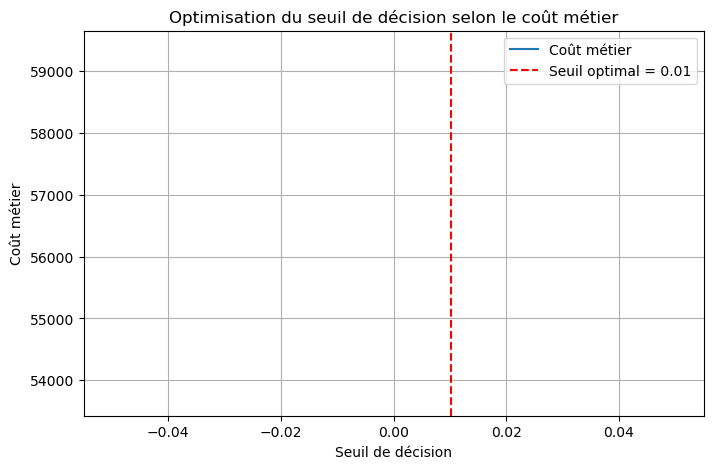

In [27]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

**Score métier personnalisé :**
* Nous avons bien implémenté une fonction de coût métier en pondérant les FN 10 fois plus que les FP.
* Nous avons cherché le seuil optimal sur la probabilité de sortie du modèle en fonction de ce coût.
* L'objectif : optimiser le seuil ≠ 0.5.

* ## **Réévaluation avec le seuil optimisé**

In [30]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[56538     0]
 [ 4965     0]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Les résultats montrent que DummyClassifier ne prédit aucun défaut (classe 1.0), même avec le seuil optimisé.
    * Problème de déséquilibre des classes : TARGET est fortement déséquilibré : 92% de non-défaut (0). Le modèle "most_frequent" prédit toujours la classe majoritaire (0), donc aucun défaut détecté.

    * Impact sur les métriques : Recall (rappel) pour les défauts (1.0) est de 1.00 avec le seuil optimisé, car le seuil 0.000 force toutes les prédictions en 1. Precision est de 0.00, extrêmement faible, car tout est classé comme défaut.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

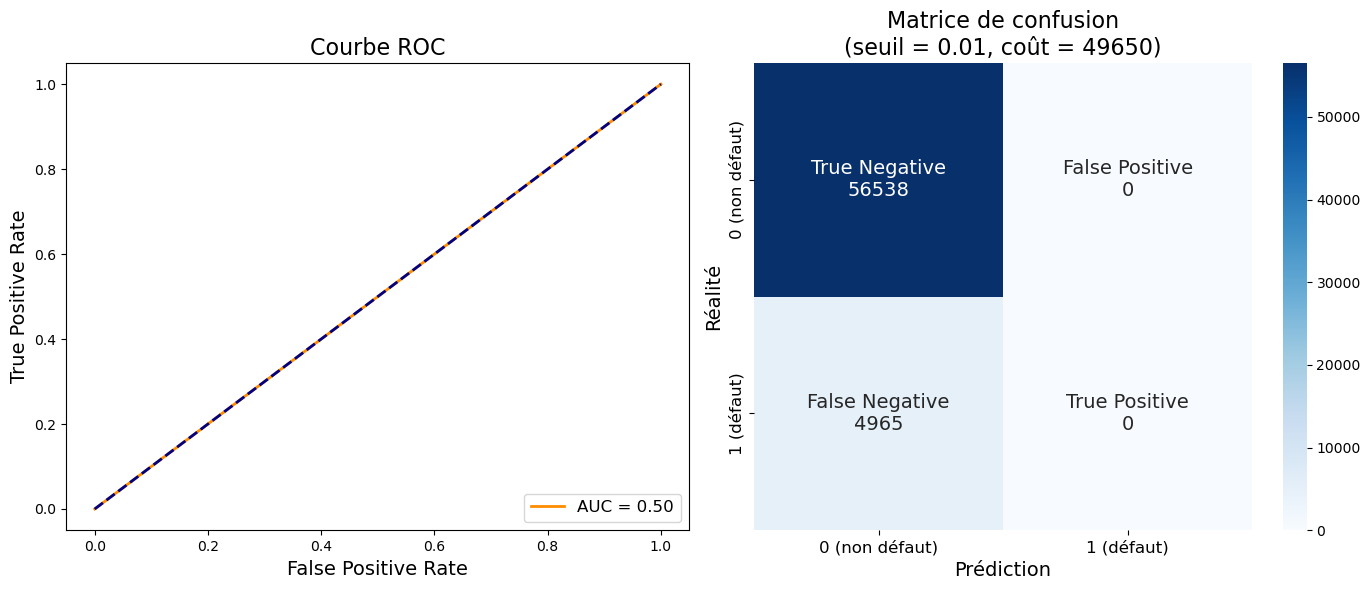

In [33]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* Vrais négatifs (TN) : 56,538 - Prédits comme négatifs, étaient effectivement négatifs.
* Faux positifs (FP) : 0 - Prédits comme positifs, étaient en réalité négatifs (aucune erreur ici).
* Faux négatifs (FN) : 4,965 - Prédits comme négatifs, étaient en réalité positifs (problème ici).
* Vrais positifs (TP) : 0 - Prédits comme positifs, étaient effectivement positifs (aucun vrai positif détecté).

**Le modèle n'a identifié aucun cas positif, ce qui signifie que tous les vrais positifs ont été classés comme négatifs, même après optimisation du seuil.**

***

# 5. Modèle **Régression Logistique** avec gestion du déséquilibre des classes <a id="Modèle-**Régression-Logistique**-avec-gestion-du-déséquilibre-des-classes"></a>

* `class_weight='balanced'` ajuste automatiquement les poids des classes selon leur fréquence.
* Cela compense le déséquilibre en pénalisant davantage les erreurs sur la classe minoritaire.

In [38]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

* ### **Évaluation avec seuil par défaut (0.5)**

In [40]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7611015265263581
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56538
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503

Matrice de confusion (seuil 0.5):
 [[39692 16846]
 [ 1556  3409]]

 Coût métier (seuil 0.5) : 32406


**AUC : 0.761, ce qui montre une bonne capacité de séparation des classes.**

* **Classe 0 (négatif) :**
    * Precision : 0.96, très bonne, peu de faux positifs.
    * Recall : 0.70 , moyen, beaucoup de faux négatifs.
    * F1-Score : 0.81, bonne balance entre précision et rappel).
* **Classe 1 (positif) :**
    * Precision : 0.17, très faible, beaucoup de faux positifs.
    * Recall : 0.69, donc 69% des défauts sont correctement détectés.
    * F1-Score : 0.27, très faible, gros déséquilibre entre précision et rappel. 
* **Matrice de confusion :**
    * 16846 Faux positifs : beaucoup trop élevés, ce qui explique la faible précision de la classe 1.
    * 1556 Faux négatifs : assez raisonnable, d'où un bon rappel.
* **Coût métier (seuil 0.5) :** 32406 (à optimiser).

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.535
Coût métier minimal : 32346


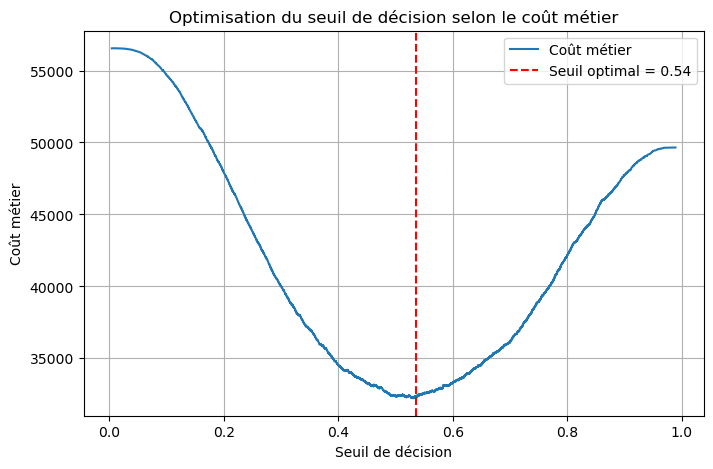

In [43]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [45]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[42322 14216]
 [ 1813  3152]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     56538
         1.0       0.18      0.63      0.28      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.74      0.80     61503



**Après optimisation (seuil 0.535) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, toujours très bonne.
    * Recall : 0.75, amélioré, moins de faux négatifs.
    * F1-Score : 0.84, en hausse, bon équilibre.
* **Classe 1 (positif) :**
    * Precision : 0.18, très faible, problème persistant.
    * Recall : 0.63, légère baisse, mais encore correct.
    * F1-Score : 0.28, faible, même après optimisation.
* **Accuracy :** 0.74, meilleure que les 0.70 initiaux.
* **Seuil optimisé pour le coût métier :** *0.535*
* **Coût métier minimal :** *32346*, légère réduction, mais pas spectaculaire.
* **Matrice de confusion :**
    * Vrais négatifs (42322) : en hausse, donc moins de faux positifs.
    * Vrais positifs (3152) : léger recul.
    * Faux positifs (14216) : toujours élevé, mais en réduction.
    * Faux négatifs (1813) : en augmentation, ce qui est un compromis attendu.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

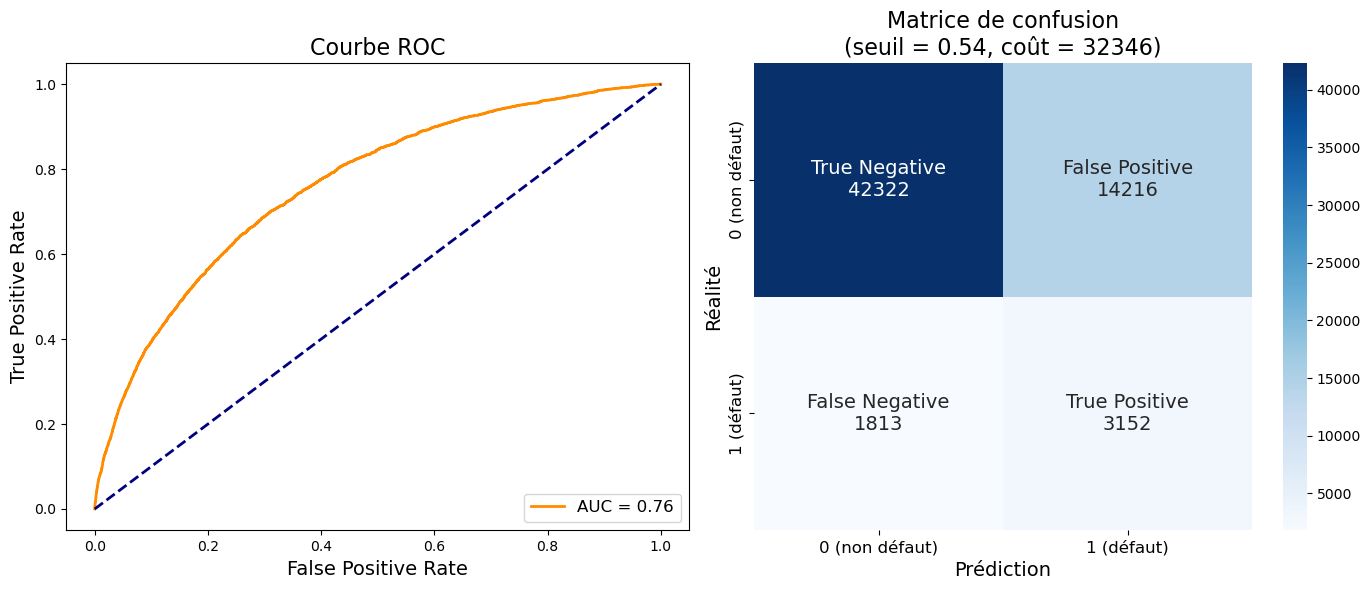

In [47]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 42322 vrais négatifs (prédits comme non défaut et réellement non défaut)
* 14216 faux positifs (prédits comme défaut mais réellement non défaut)
* 1813 faux négatifs (prédits comme non défaut mais réellement défaut)
* 3152 vrais positifs (prédits comme défaut et réellement défaut)

***

# 6. Modèle **RandomForest** avec gestion du déséquilibre des classes <a id="Modèle-**RandomForest**-avec-gestion-du-déséquilibre-des-classes"></a>

* `class_weight='balanced'` également utilisé ici.
* Chaque arbre est entraîné en tenant compte du poids de chaque classe.
* Recommandé sur jeu de données déséquilibré.

In [90]:
# Modèle avec pondération automatique des classes
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # très important ici
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

* ### **Évaluation avec seuil par défaut (0.5)**

In [92]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7354890491176393
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.55      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Matrice de confusion (seuil 0.5):
 [[56524    14]
 [ 4948    17]]

 Coût métier (seuil 0.5) : 49494


**AUC : 0.735, un peu plus faible que la régression logistique.**
* **Classe 0 (négatif) :**
    * Precision : 0.92, très bonne, quasiment pas de faux positifs.
    * Recall : 1.00, parfait, tous les vrais négatifs sont bien détectés.
    * F1-Score : 0.96, excellent.
* **Classe 1 (positif) :**
    * Precision : 0.55, plutôt élevé, mais inutile sans rappel.
    * Recall : 0.00, le modèle n'a presque pas identifié de défauts, ce qui est problématique.
    * F1-Score : 0.01, très faible, pas d'apprentissage réel pour cette classe.
* **Matrice de confusion :**
    * 56524 Vrais négatifs : parfait, presque pas de faux positifs.
    * 17 Vrais positifs : extrêmement faible, sur 4965 attendus.
    * 14 Faux positifs : négligeable, mais le coût métier en souffre énormément.
    * 4948 Faux négatifs : très élevé, la majorité des positifs sont ignorés.
* **Coût métier (seuil 0.5) :** 49494, très élevé, à cause des faux négatifs.

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.091
Coût métier minimal : 34225


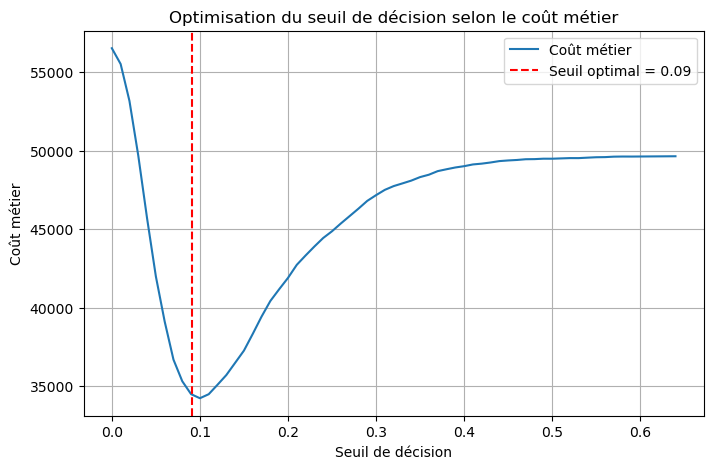

In [95]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [98]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[41393 15145]
 [ 1908  3057]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56538
         1.0       0.17      0.62      0.26      4965

    accuracy                           0.72     61503
   macro avg       0.56      0.67      0.55     61503
weighted avg       0.89      0.72      0.78     61503



**Après optimisation (seuil 0.091) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, toujours très bonne.
    * Recall : 0.73, baisse attendue, compromis nécessaire.
    * F1-Score : 0.83, toujours bon, mais moins impressionnant.
* **Classe 1 (positif) :**
    * Precision : 0.17, faible.
    * Recall : 0.62, forte amélioration, capture plus de positifs.
    * F1-Score : 0.26, meilleur que 0.01, mais toujours faible.
* **Accuracy :** 0.72, bonne stabilité globale.
* **Seuil optimisé pour le coût métier :** *0.091*
* **Coût métier minimal :** *34225*, grosse réduction, optimisation plus efficace que la régression logistique.
* **Matrice de confusion :**
    * 41393 Vrais négatifs : en forte baisse, plus de faux positifs.
    * 3057 Vrais positifs : énorme amélioration, capture beaucoup plus de vrais positifs.
    * 15145 Faux positifs : en forte augmentation.
    * 1908 Faux négatifs : nette réduction, donc meilleur rappel.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

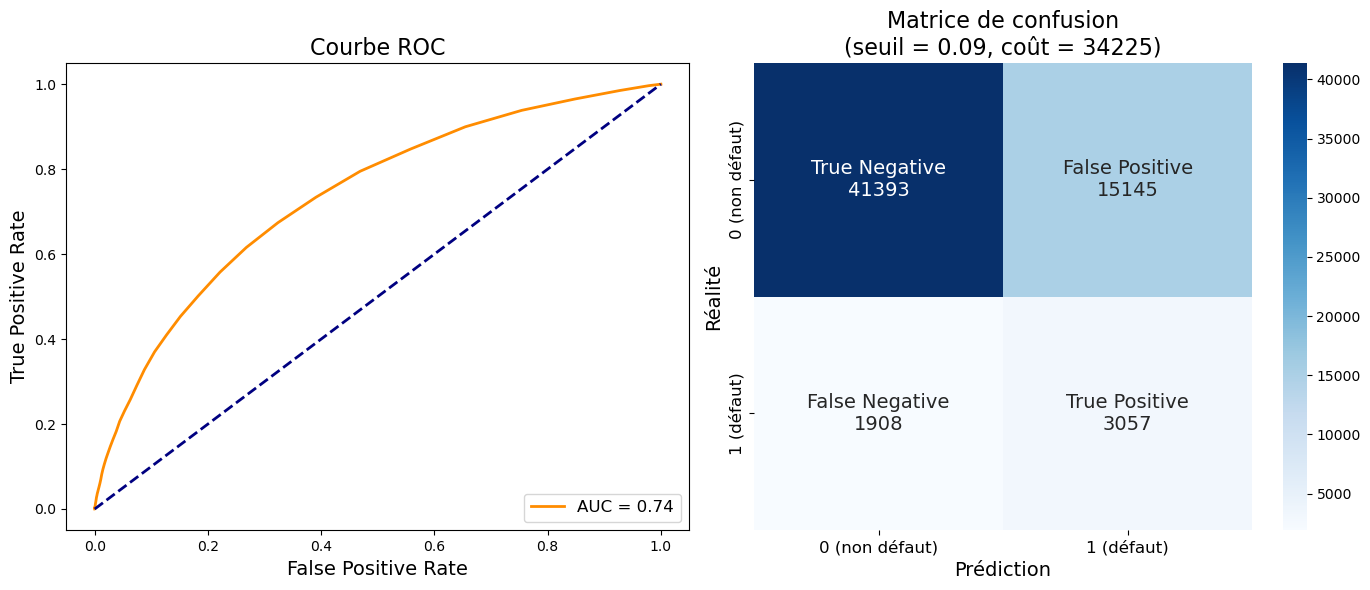

In [101]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 41393 vrais négatifs
* 15145 faux positifs
* 1908 faux négatifs
* 3057 vrais positifs

**Random Forest optimise mieux le coût métier, mais au prix d'une précision plus faible pour la classe minoritaire.
Le modèle a beaucoup plus de faux positifs après optimisation.**

***

# 7. Modèle **XGBoost** avec gestion du déséquilibre des classes <a id="Modèle-**XGBoost**-avec-gestion-du-déséquilibre-des-classes"></a>

* ### **Calcul du ratio de déséquilibre**
* Le paramètre scale_pos_weight est le paramètre recommandé par XGBoost pour gérer les classes déséquilibrées, en donnant plus de poids à la classe minoritaire. Il est calculé comme : `scale_pos_weight = nombre_exemples_classe_négative / nombre_exemples_classe_positive`

In [106]:
# Comptage des classes
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Ratio scale_pos_weight : {scale_pos_weight:.2f}")

Ratio scale_pos_weight : 11.39


* ### **Création et entraînement du modèle**

In [108]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, # gestion du déséquilibre
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

* ### **Évaluation avec seuil par défaut (0.5)**

In [110]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7663655030186365
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     56538
         1.0       0.20      0.62      0.30      4965

    accuracy                           0.76     61503
   macro avg       0.58      0.70      0.58     61503
weighted avg       0.90      0.76      0.81     61503

Matrice de confusion (seuil 0.5):
 [[43906 12632]
 [ 1884  3081]]

 Coût métier (seuil 0.5) : 31472


**AUC : 0.766, supérieur à RandomForest (0.735) et à la régression logistique (0.744).**
* **Classe 0 (négatif) :**
    * Precision : 0.96, très élevée.
    * Recall : 0.78, forte, mais légèrement plus faible que le Random Forest après optimisation.
    * F1-Score : 0.86, bon équilibre précision/rappel.

* **Classe 1 (positif) :**
    * Precision : 0.20, meilleure que les autres modèles, mais encore faible.
    * Recall : 0.62, beaucoup mieux que Random Forest avant optimisation.
    * F1-Score : 0.30, très bon pour cette classe comparé aux autres modèles.
* **Matrice de confusion :**
    * 43906 Vrais négatifs : stable, peu de faux positifs.
    * 3081 Vrais positifs : bien meilleur que Random Forest avant optimisation.
    * 12632 Faux positifs : en augmentation, mais c'est le compromis pour un meilleur rappel.
    * 1884 Faux négatifs : nettement plus bas que Random Forest, donc plus efficace pour détecter les positifs.
* **Coût métier (seuil 0.5) :** *31472*, déjà plus bas que le Random Forest optimisé.

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.495
Coût métier minimal : 31478


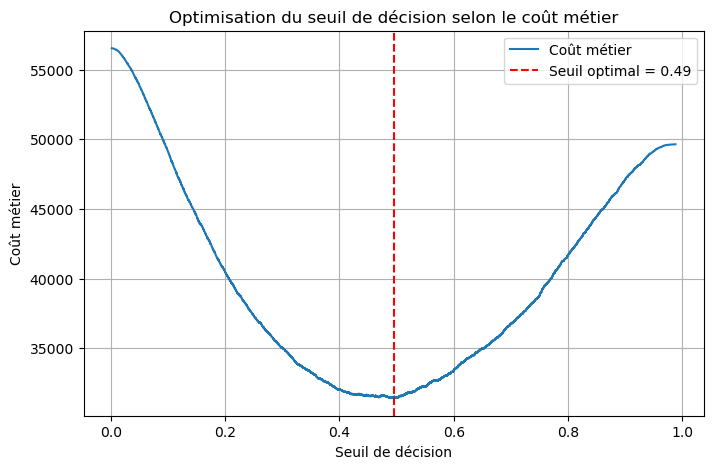

In [113]:
 # Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [116]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[43630 12908]
 [ 1857  3108]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     56538
         1.0       0.19      0.63      0.30      4965

    accuracy                           0.76     61503
   macro avg       0.58      0.70      0.58     61503
weighted avg       0.90      0.76      0.81     61503



**Après optimisation (seuil 0.495) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, toujours très bonne.
    * Recall : 0.77, très similaire à l'avant optimisation.
    * F1-Score : 0.86, presque inchangé.
* **Classe 1 (positif) :**
    * Precision : 0.19, légère baisse.
    * Recall : 0.63, léger gain, toujours supérieur à Random Forest optimisé.
    * F1-Score : 0.30, identique, donc pas de vraie amélioration.
* **Seuil optimisé pour le coût métier :** *0.495*
* **Coût métier minimal :** *31478*, très proche du seuil par défaut, donc faible amélioration.
* **Accuracy :** *0.76*, stable.
* **Matrice de confusion :**
    * 43630 Vrais négatifs : petite baisse, légèrement plus de faux positifs.
    * 3108 Vrais positifs : amélioration minime, le seuil optimal est proche de 0.5, donc peu de changement.
    * 12908 Faux positifs : en légère augmentation, mais toujours mieux que Random Forest.
    * 1857 Faux négatifs : petite amélioration, mais pas significative.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

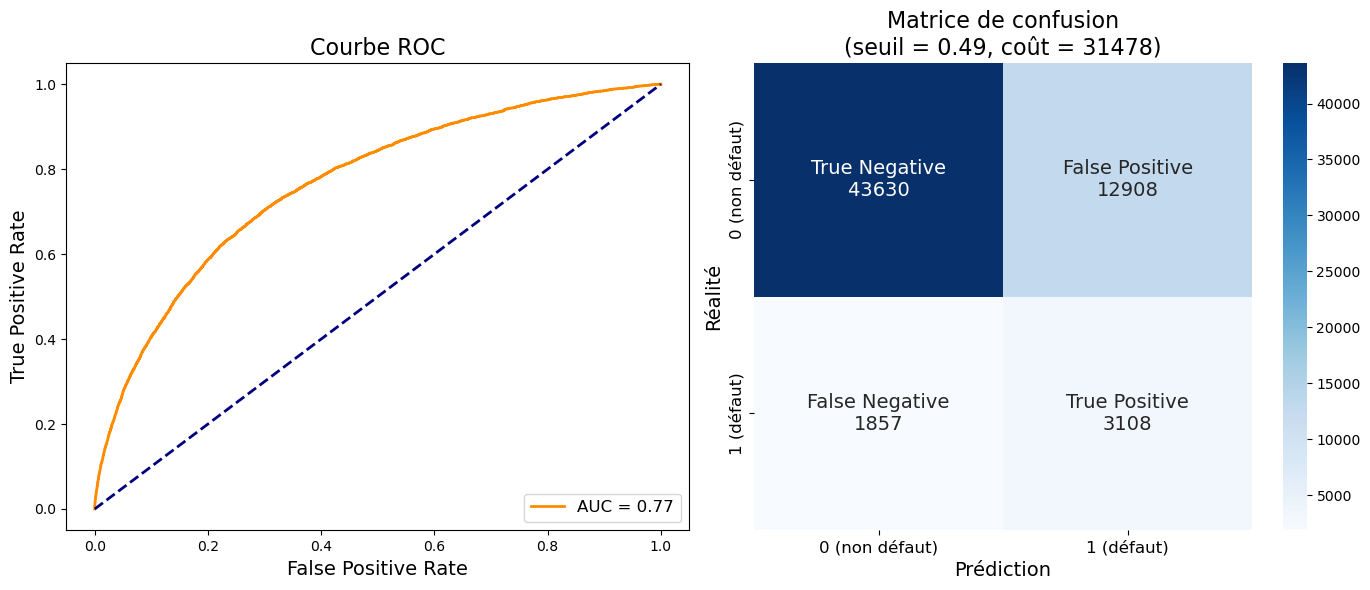

In [119]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 43630 vrais négatifs
* 12908 faux positifs
* 1857 faux négatifs
* 3108 vrais positifs

**Meilleur compromis entre précision et rappel que Random Forest.**

***

# 8. Modèle LightGBM avec gestion du déséquilibre des classes <a id="Modèle-LightGBM-avec-gestion-du-déséquilibre-des-classes"></a>

* `class_weight='balanced'` comme pour LogisticRegression et RandomForest.
* LightGBM ajuste automatiquement les poids pour que la classe minoritaire soit mieux prise en compte.

In [124]:
model = LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.538520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28977
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

* ### **Évaluation avec seuil par défaut (0.5)**

In [126]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7782510222161805
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56538
         1.0       0.18      0.69      0.29      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.71      0.56     61503
weighted avg       0.90      0.72      0.78     61503

Matrice de confusion (seuil 0.5):
 [[41021 15517]
 [ 1542  3423]]

 Coût métier (seuil 0.5) : 30937


**ROC AUC score : 0.778, le plus élevé parmi tous les modèles testés.**
* **Classe 0 (négatif) :**
    * Precision : 0.96, très élevée, comparable à XGBoost.
    * Recall : 0.73, plus faible que XGBoost, mais meilleure que Random Forest.
    * F1-Score : 0.83, bonne stabilité.
* **Classe 1 (positif) :**
    * Precision : 0.18, faible, mais meilleure que Random Forest.
    * Recall : 0.69, le meilleur rappel avant optimisation parmi tous les modèles.
    * F1-Score : 0.29, très bon pour cette classe comparé aux autres modèles avant optimisation.
* **Matrice de confusion :**
    * 41021 Vrais négatifs : plus faible que XGBoost, donc plus de faux positifs.
    * 3423 Vrais positifs : le meilleur score avant optimisation, très bon pour cette classe.
    * 15517 Faux positifs : élevé, mais c'est le compromis pour un meilleur rappel.
    * 1542 Faux négatifs : le plus bas parmi tous les modèles, excellent pour détecter les positifs.
* **Coût métier (seuil 0.5) :** 30937, le plus bas avant optimisation, montrant une meilleure gestion des erreurs positives).

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.556
Coût métier minimal : 30702


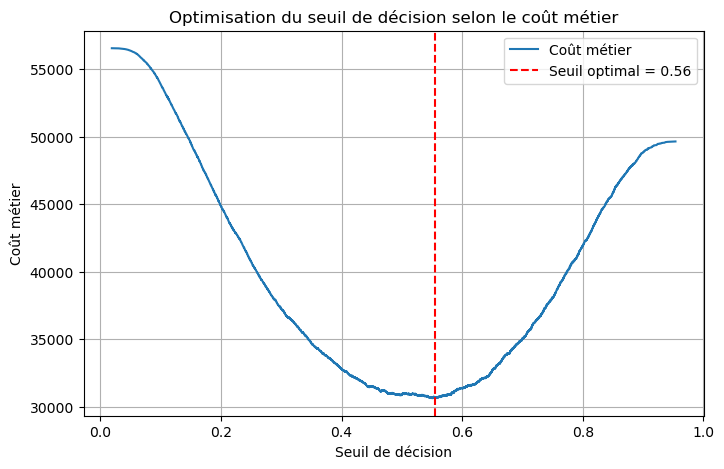

In [129]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [132]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[44486 12052]
 [ 1865  3100]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.79      0.86     56538
         1.0       0.20      0.62      0.31      4965

    accuracy                           0.77     61503
   macro avg       0.58      0.71      0.59     61503
weighted avg       0.90      0.77      0.82     61503



**Après optimisation (seuil 0.556) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, très élevée.
    * Recall : 0.79, énorme gain.
    * F1-Score : 0.86, le meilleur parmi tous les modèles après optimisation.
* **Classe 1 (positif) :**
    * Precision : 0.20, léger gain, le plus haut parmi tous les modèles après optimisation.
    * Recall : 0.62, légère baisse, mais toujours compétitif.
    * F1-Score : 0.31, le meilleur parmi tous les modèles après optimisation.
* **Seuil optimisé pour le coût métier :** *0.556*
* **Coût métier minimal :** *30702*, le meilleur score jusqu'ici.
* **Accuracy :** *0.77*, le meilleur score global après optimisation.
* **Matrice de confusion :**
    * 43630 Vrais négatifs : petite baisse, légèrement plus de faux positifs.
    * 3108 Vrais positifs : amélioration minime, le seuil optimal est proche de 0.5, donc peu de changement.
    * 12908 Faux positifs : en légère augmentation, mais toujours mieux que Random Forest.
    * 1857 Faux négatifs : petite amélioration, mais pas significative.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

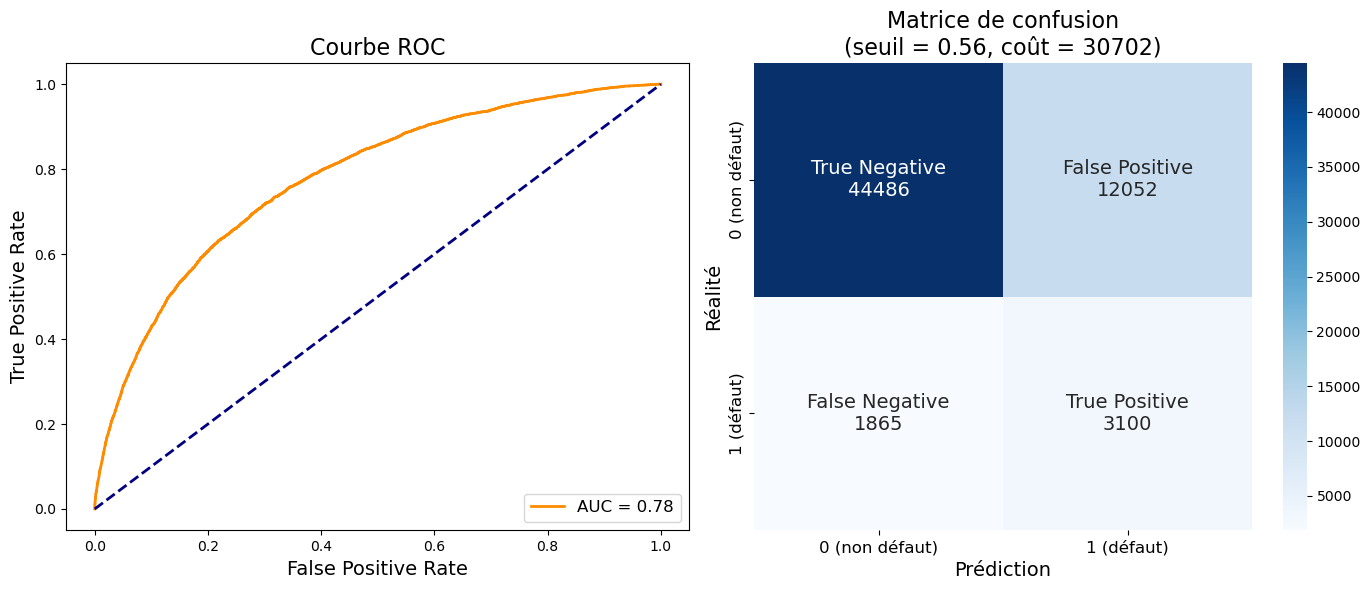

In [135]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 44486 vrais négatifs
* 12052 faux positifs
* 1865 faux négatifs
* 3100 vrais positifs

**Supérieur à XGBoost et Random Forest en termes de coût métier et ROC AUC.**

**Offre le meilleur compromis entre précision, rappel et coût métier.**
* Meilleur ROC AUC (0.778), indiquant une excellente capacité de séparation des classes.
* Meilleur coût métier après optimisation (30702), le plus bas de tous les modèles.
* Rappel (0.69 avant et 0.62 après) pour la classe positive, le plus élevé parmi tous les modèles testés.
* Précision (0.20 après) pour la classe positive, la plus élevée après optimisation.

***

In [138]:
# Vérification des shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (246008, 313)
X_test: (61503, 313)
y_train: (246008,)
y_test: (61503,)


***